This notebook is for making timeseries from composites corresponding to extreme NAO events. 

In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read data for NAO and compute seasonal values

ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly_new.nc")

#NAO_season = ds_NAO['NAO'].copy()
NAO_season = (ds_NAO['P_south'] - ds_NAO['P_north']) # for NAO indices in pa

tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

%time NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

CPU times: user 28.3 ms, sys: 10.1 ms, total: 38.4 ms
Wall time: 40.1 ms


In [3]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['mlotst', 'tos', 'tauu', 'Heat_Budget']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

ds_NAOp = ds_NAOp.mean('comp')
ds_NAOn = ds_NAOn.mean('comp')

print(ds_NAOp)

ds_psi_NAOp = xr.open_dataset(ppdir + "Composite_NAOp_Overturning.nc", chunks={'time':1})

ds_psi_NAOn = xr.open_dataset(ppdir + "Composite_NAOn_Overturning.nc", chunks={'time':1})

print(ds_psi_NAOp)

<xarray.Dataset>
Dimensions:                          (j: 321, i: 361, time: 101, lat: 99,
                                      lon: 432)
Coordinates:
  * j                                (j) int32 780 781 782 ... 1098 1099 1100
  * i                                (i) int32 810 811 812 ... 1168 1169 1170
    latitude                         (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude                        (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
  * lat                              (lat) float64 20.28 20.83 ... 74.17 74.72
  * lon                              (lon) float64 0.0 0.8333 ... 358.3 359.2
    nav_lat                          (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    nav_lon                          (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
Dimensions without coordinates: time
Data variables: (12/13)
    mlotst                           (time, j, i) float32 dask.arr

In [12]:
# read overturning drift data for climatology plots

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Drift/psi_sigma/"

ds_drift = []

for r in range(0,10):
    
    ds1 = []
    
    for lead_year in range(0, 11):
        
        d = xr.open_dataset(ppdir + "Drift_Overturning_r" + str(r+1) + "_Lead_Year_" +
                            str(lead_year + 1) + ".nc", decode_times= False)
        
        d = d.assign(time = np.arange(lead_year*12, 12*lead_year + 
                                      np.minimum(12, len(d['time'])), 1))
        
        ds1.append(d)
        
    ds1 = xr.concat(ds1, dim='time')
    
    ds_drift.append(ds1)
    
ds_drift = xr.concat(ds_drift, dim='r')

print(ds_drift)

<xarray.Dataset>
Dimensions:                (j_c: 450, r: 10, time: 125, lev: 75, sigma0: 48,
                            lat: 153)
Coordinates:
  * j_c                    (j_c) int32 699 700 701 702 ... 1145 1146 1147 1148
  * lev                    (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
  * sigma0                 (sigma0) float64 16.0 18.0 19.5 ... 28.9 29.5 30.5
  * lat                    (lat) float64 0.2778 0.8333 1.389 ... 84.17 84.72
  * time                   (time) int64 0 1 2 3 4 5 ... 119 120 121 122 123 124
Dimensions without coordinates: r
Data variables:
    latitude               (r, time, j_c) float32 4.121 4.371 ... 75.82 75.9
    Overturning_z          (r, time, lev, j_c) float64 1.591e+06 ... 0.0
    Overturning_sigma      (r, time, j_c, sigma0) float64 2.525e+04 ... -3.64...
    MHT_sigma              (r, time, j_c, sigma0) float64 2.92e+12 ... 0.0
    MHT_overturning_sigma  (r, time, j_c, sigma0) float64 4.08e+10 ... 0.0
    MHT_z                  (r, t

#### Figure for timeseris for NAO+ case

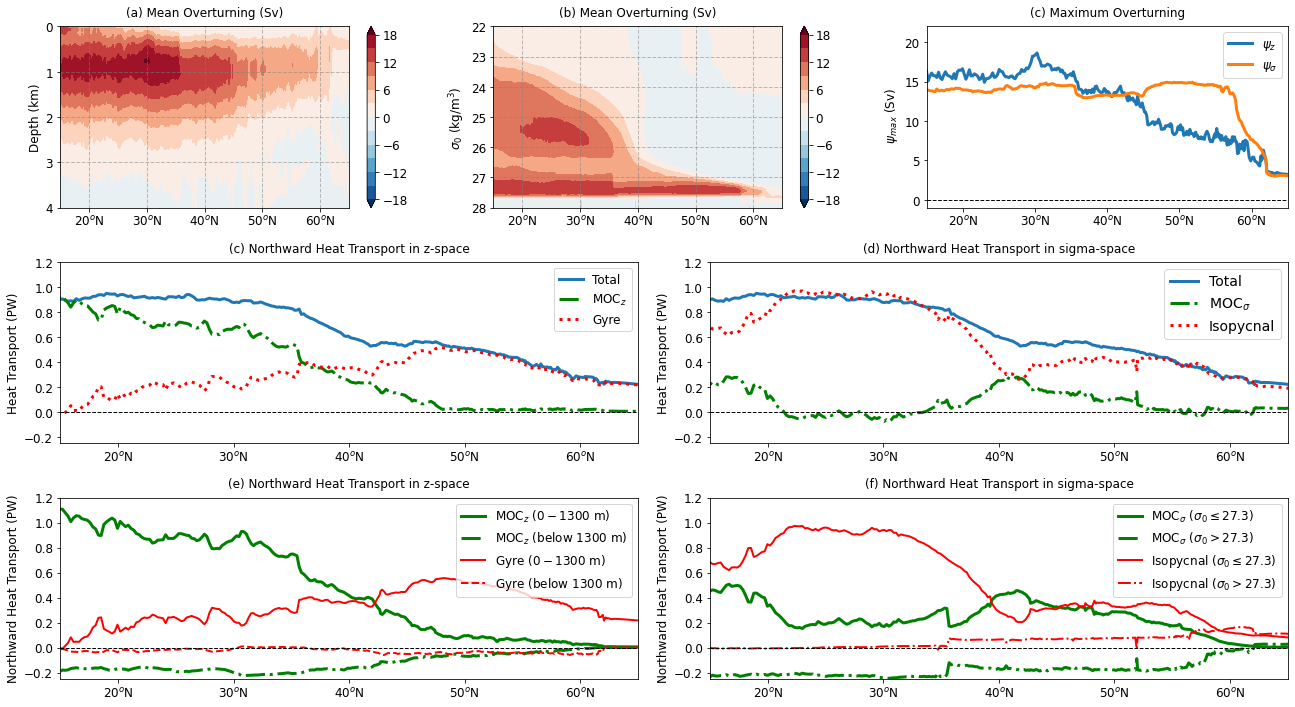

In [91]:
grid1 = plt.GridSpec(3, 6, wspace=0.5, hspace=0.3)
fig = plt.figure(figsize=[22,12])

lat = ds_psi_NAOp['latitude']

tmp = ds_drift['Overturning_z'].mean(['r','time']).isel(j_c=slice(0,340)) / 1e6
tmp = tmp.assign_coords(j_c=lat.isel(j_c=slice(0,340)))

ax = fig.add_subplot(grid1[0, 0:2])
p = tmp.plot.contourf(ax=ax, x='j_c', y='lev', levels = 13, vmin = -18, vmax = 18.,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
ax.set_ylabel('Depth (km)', fontsize=12)
cb = fig.colorbar(p, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], fontsize = 12);
plt.yticks(np.arange(0,4500,1000), [r'0', r'1', r'2', r'3', r'4'])
ax.set_ylim([0., 4000.])
ax.set_xlim([15., 65.])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.set_title('(a) Mean Overturning (Sv)', pad=10, fontsize=12)
plt.gca().invert_yaxis()
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

tmp = ds_drift['Overturning_sigma'].mean(['r','time']).isel(j_c=slice(0,340)) / 1e6
tmp = tmp.assign_coords(j_c=lat.isel(j_c=slice(0,340)))

ax = fig.add_subplot(grid1[0, 2:4])
p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 13, vmin = -18, vmax = 18.,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
cb = fig.colorbar(p, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], fontsize = 12);
ax.set_ylim([22., 28.])
ax.set_xlim([15., 65.])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.set_title('(b) Mean Overturning (Sv)', pad=10, fontsize=12)
plt.gca().invert_yaxis()
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

ax = fig.add_subplot(grid1[0, 4:6])
ax.plot(lat, ds_drift['Overturning_z'].max('lev').mean(['r', 'time'])/1e6, lw=3, label=r'$\psi_z$')
ax.plot(lat, ds_drift['Overturning_sigma'].max('sigma0').mean(['r', 'time'])/1e6, lw=3, label=r'$\psi_{\sigma}$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=12)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
ax.set_ylabel(r' $\psi_{max}$ (Sv)', fontsize=12)
ax.set_ylim([-1., 22.])
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(c) Maximum Overturning', pad=10, fontsize=12)

ax = fig.add_subplot(grid1[1, 0:3])
ax.plot(lat, ds_drift['MHT_z'].sum('lev').mean(['r', 'time'])/1e15, lw=3, label=r'Total')
ax.plot(lat, ds_drift['MHT_overturning_z'].sum('lev').mean(['r', 'time'])/1e15, lw=3, ls='-.',
       label =r'MOC$_z$', color='green')
ax.plot(lat, (ds_drift['MHT_z'] - ds_drift['MHT_overturning_z']).sum('lev').mean(['r', 'time'])/1e15,  
        lw=3, ls=':', label=r'Gyre', color='red')
ax.set_ylim([-0.25, 1.2])
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(c) Northward Heat Transport in z-space', pad=10, fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.set_ylabel('Heat Transport (PW)', fontsize=12)

ax = fig.add_subplot(grid1[1, 3:6])
ax.plot(lat, ds_drift['MHT_sigma'].sum('sigma0').mean(['r', 'time'])/1e15, lw=3, label=r'Total')
ax.plot(lat, ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,37)).sum('sigma0').mean(['r', 'time'])/1e15
        + ds_drift['MHT_sigma'].isel(sigma0=slice(37,-1)).sum('sigma0').mean(['r', 'time'])/1e15, # assuming 37-48 layers HT is only due to overturning 
        lw=3, ls='-.', label =r'MOC$_{\sigma}$', color='green')
ax.plot(lat, (ds_drift['MHT_sigma'].sum('sigma0') - 
         ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,37)).sum('sigma0')).mean(['r', 'time'])/1e15
        - ds_drift['MHT_sigma'].isel(sigma0=slice(37,-1)).sum('sigma0').mean(['r', 'time'])/1e15,  
        lw=3, ls=':', label=r'Isopycnal', color='red')
ax.set_ylim([-0.25, 1.2])
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
#ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(d) Northward Heat Transport in sigma-space', pad=10, fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=14)
ax.set_ylabel('Heat Transport (PW)', fontsize=12)

ax = fig.add_subplot(grid1[2, 0:3])
ax.plot(lat, ds_drift['MHT_overturning_z'].isel(lev=slice(0,49)).sum('lev').mean(['r', 'time'])/1e15, lw=3, ls='-',
       label =r'MOC$_z$ ($0-1300$ m)', color='green')
ax.plot(lat, ds_drift['MHT_overturning_z'].isel(lev=slice(49,75)).sum('lev').mean(['r', 'time'])/1e15, lw=3, ls='-.',
       label =r'MOC$_z$ (below $1300$ m)', color='green')
ax.plot(lat, (ds_drift['MHT_z'] - ds_drift['MHT_overturning_z']).isel(lev=slice(0,49)).sum('lev').mean(['r', 'time'])/1e15,  
        lw=2., ls='-', label=r'Gyre ($0-1300$ m)', color='red')
ax.plot(lat, (ds_drift['MHT_z'] - ds_drift['MHT_overturning_z']).isel(lev=slice(49,75)).sum('lev').mean(['r', 'time'])/1e15,  
        lw=2., ls='--', label=r'Gyre (below $1300$ m)', color='red')
ax.set_ylim([-0.25, 1.2])
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(e) Northward Heat Transport in z-space', pad=10, fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.set_ylabel('Northward Heat Transport (PW)', fontsize=12)

ax = fig.add_subplot(grid1[2, 3:6])
ax.plot(lat, ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,34)).sum('sigma0').mean(['r', 'time'])/1e15, 
        lw=3, ls='-', label =r'MOC$_{\sigma}$ ($\sigma_0 \leq 27.3$)', color='green')
ax.plot(lat, ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(34,37)).sum('sigma0').mean(['r', 'time'])/1e15
        + ds_drift['MHT_sigma'].isel(sigma0=slice(37, -1)).sum('sigma0').mean(['r', 'time'])/1e15, 
        lw=3, ls='-.', label =r'MOC$_{\sigma}$ ($\sigma_0 > 27.3$)', color='green')
ax.plot(lat, (ds_drift['MHT_sigma'].isel(sigma0=slice(0,34)).sum('sigma0') - 
         ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,34)).sum('sigma0')).mean(['r', 'time'])/1e15,  
        lw=2., ls='-', label=r'Isopycnal ($\sigma_0 \leq 27.3$)', color='red')
ax.plot(lat, (ds_drift['MHT_sigma'].isel(sigma0=slice(34,-1)).sum('sigma0') - 
         ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(34,37)).sum('sigma0')).mean(['r', 'time'])/1e15
        - ds_drift['MHT_sigma'].isel(sigma0=slice(37, -1)).sum('sigma0').mean(['r', 'time'])/1e15,  
        lw=2., ls='-.', label=r'Isopycnal ($\sigma_0>27.3$)', color='red')
ax.set_ylim([-0.25, 1.2])
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
#ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(f) Northward Heat Transport in sigma-space', pad=10, fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=12)
ax.set_ylabel('Northward Heat Transport (PW)', fontsize=12)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Climatology_Overturning.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Climatology_Overturning.pdf', dpi=300,bbox_inches='tight');

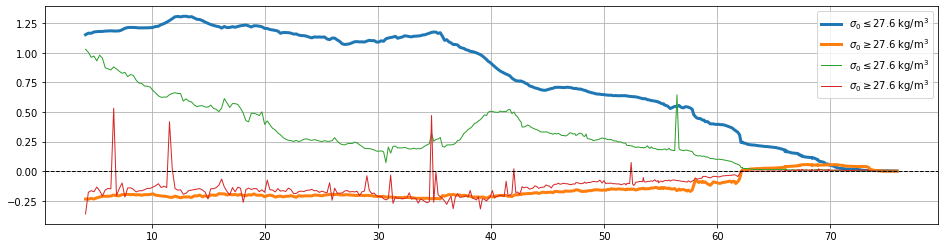

In [7]:
fig = plt.figure(figsize=[16,4])

plt.plot(lat, ds_drift['MHT_sigma'].isel(sigma0=slice(0,37)).sum('sigma0').mean(['r', 'time'])/1e15, lw=3, label=r'$\sigma_0 \leq 27.6$ kg/m$^3$')
plt.plot(lat, ds_drift['MHT_sigma'].isel(sigma0=slice(37,-1)).sum('sigma0').mean(['r', 'time'])/1e15, lw=3, label=r'$\sigma_0 \geq 27.6$ kg/m$^3$')

plt.plot(lat, ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,37)).sum('sigma0').mean(['r', 'time'])/1e15, 
         lw=1, label=r'$\sigma_0 \leq 27.6$ kg/m$^3$')
plt.plot(lat, ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(37,48)).sum('sigma0').mean(['r', 'time'])/1e15, 
         lw=1, label=r'$\sigma_0 \geq 27.6$ kg/m$^3$')
plt.axhline(y=0, ls='--', lw=1, color='k')
plt.grid()
plt.legend()

# layers 27.55, 27.65, 27.75 are noisy for overturning heat tranposrt contribution.
# Might cut-off weird peaks to smoothen the results 
# There is no heat transport in sigma > 27.8 kg/m3

Text(0, 0.5, 'Northward Heat Transport (PW)')

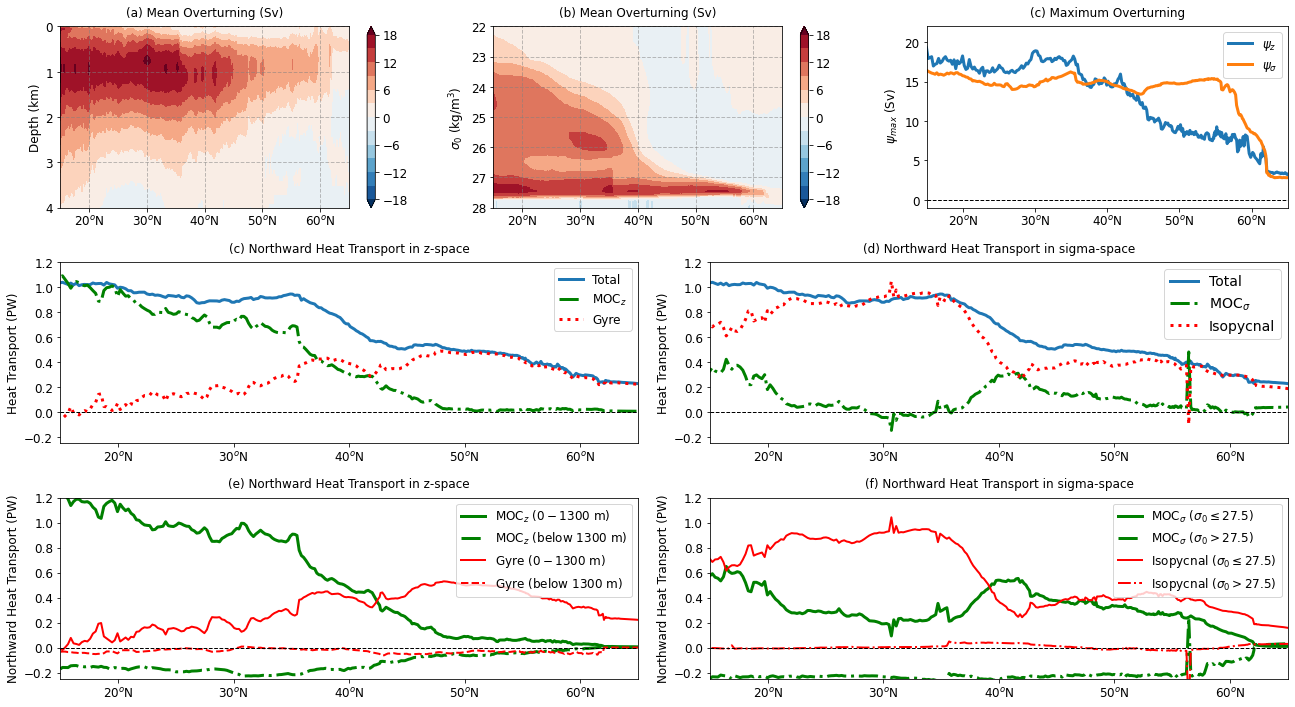

In [8]:
# This is the same as bove but onlt for one-year. This is exclude the possibility that larger isopycnal contribution is coming from model drift 

grid1 = plt.GridSpec(3, 6, wspace=0.5, hspace=0.3)
fig = plt.figure(figsize=[22,12])

lat = ds_psi_NAOp['latitude']

ds_drift = ds_drift.isel(time=slice(0,12))

tmp = ds_drift['Overturning_z'].isel(time=slice(0,12)).mean(['r','time']).isel(j_c=slice(0,340)) / 1e6
tmp = tmp.assign_coords(j_c=lat.isel(j_c=slice(0,340)))

ax = fig.add_subplot(grid1[0, 0:2])
p = tmp.plot.contourf(ax=ax, x='j_c', y='lev', levels = 13, vmin = -18, vmax = 18.,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
ax.set_ylabel('Depth (km)', fontsize=12)
cb = fig.colorbar(p, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], fontsize = 12);
plt.yticks(np.arange(0,4500,1000), [r'0', r'1', r'2', r'3', r'4'])
ax.set_ylim([0., 4000.])
ax.set_xlim([15., 65.])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.set_title('(a) Mean Overturning (Sv)', pad=10, fontsize=12)
plt.gca().invert_yaxis()
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

tmp = ds_drift['Overturning_sigma'].mean(['r','time']).isel(j_c=slice(0,340)) / 1e6
tmp = tmp.assign_coords(j_c=lat.isel(j_c=slice(0,340)))

ax = fig.add_subplot(grid1[0, 2:4])
p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 13, vmin = -18, vmax = 18.,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
cb = fig.colorbar(p, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], fontsize = 12);
ax.set_ylim([22., 28.])
ax.set_xlim([15., 65.])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.set_title('(b) Mean Overturning (Sv)', pad=10, fontsize=12)
plt.gca().invert_yaxis()
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

ax = fig.add_subplot(grid1[0, 4:6])
ax.plot(lat, ds_drift['Overturning_z'].max('lev').mean(['r', 'time'])/1e6, lw=3, label=r'$\psi_z$')
ax.plot(lat, ds_drift['Overturning_sigma'].max('sigma0').mean(['r', 'time'])/1e6, lw=3, label=r'$\psi_{\sigma}$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=12)
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
ax.set_ylabel(r' $\psi_{max}$ (Sv)', fontsize=12)
ax.set_ylim([-1., 22.])
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(c) Maximum Overturning', pad=10, fontsize=12)

ax = fig.add_subplot(grid1[1, 0:3])
ax.plot(lat, ds_drift['MHT_z'].sum('lev').mean(['r', 'time'])/1e15, lw=3, label=r'Total')
ax.plot(lat, ds_drift['MHT_overturning_z'].sum('lev').mean(['r', 'time'])/1e15, lw=3, ls='-.',
       label =r'MOC$_z$', color='green')
ax.plot(lat, (ds_drift['MHT_z'] - ds_drift['MHT_overturning_z']).sum('lev').mean(['r', 'time'])/1e15,  
        lw=3, ls=':', label=r'Gyre', color='red')
ax.set_ylim([-0.25, 1.2])
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(c) Northward Heat Transport in z-space', pad=10, fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.set_ylabel('Heat Transport (PW)', fontsize=12)

ax = fig.add_subplot(grid1[1, 3:6])
ax.plot(lat, ds_drift['MHT_sigma'].sum('sigma0').mean(['r', 'time'])/1e15, lw=3, label=r'Total')
ax.plot(lat, ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,37)).sum('sigma0').mean(['r', 'time'])/1e15
        + ds_drift['MHT_sigma'].isel(sigma0=slice(37,-1)).sum('sigma0').mean(['r', 'time'])/1e15, # assuming 37-48 layers HT is only due to overturning 
        lw=3, ls='-.', label =r'MOC$_{\sigma}$', color='green')
ax.plot(lat, (ds_drift['MHT_sigma'].sum('sigma0') - 
         ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,37)).sum('sigma0')).mean(['r', 'time'])/1e15
        - ds_drift['MHT_sigma'].isel(sigma0=slice(37,-1)).sum('sigma0').mean(['r', 'time'])/1e15,  
        lw=3, ls=':', label=r'Isopycnal', color='red')
ax.set_ylim([-0.25, 1.2])
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
#ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(d) Northward Heat Transport in sigma-space', pad=10, fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=14)
ax.set_ylabel('Heat Transport (PW)', fontsize=12)

ax = fig.add_subplot(grid1[2, 0:3])
ax.plot(lat, ds_drift['MHT_overturning_z'].isel(lev=slice(0,49)).sum('lev').mean(['r', 'time'])/1e15, lw=3, ls='-',
       label =r'MOC$_z$ ($0-1300$ m)', color='green')
ax.plot(lat, ds_drift['MHT_overturning_z'].isel(lev=slice(49,75)).sum('lev').mean(['r', 'time'])/1e15, lw=3, ls='-.',
       label =r'MOC$_z$ (below $1300$ m)', color='green')
ax.plot(lat, (ds_drift['MHT_z'] - ds_drift['MHT_overturning_z']).isel(lev=slice(0,49)).sum('lev').mean(['r', 'time'])/1e15,  
        lw=2., ls='-', label=r'Gyre ($0-1300$ m)', color='red')
ax.plot(lat, (ds_drift['MHT_z'] - ds_drift['MHT_overturning_z']).isel(lev=slice(49,75)).sum('lev').mean(['r', 'time'])/1e15,  
        lw=2., ls='--', label=r'Gyre (below $1300$ m)', color='red')
ax.set_ylim([-0.25, 1.2])
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(e) Northward Heat Transport in z-space', pad=10, fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.set_ylabel('Northward Heat Transport (PW)', fontsize=12)

ax = fig.add_subplot(grid1[2, 3:6])
ax.plot(lat, ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,36)).sum('sigma0').mean(['r', 'time'])/1e15, 
        lw=3, ls='-', label =r'MOC$_{\sigma}$ ($\sigma_0 \leq 27.5$)', color='green')
ax.plot(lat, ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(36,37)).sum('sigma0').mean(['r', 'time'])/1e15
        + ds_drift['MHT_sigma'].isel(sigma0=slice(37, -1)).sum('sigma0').mean(['r', 'time'])/1e15, 
        lw=3, ls='-.', label =r'MOC$_{\sigma}$ ($\sigma_0 > 27.5$)', color='green')
ax.plot(lat, (ds_drift['MHT_sigma'].isel(sigma0=slice(0,36)).sum('sigma0') - 
         ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(0,36)).sum('sigma0')).mean(['r', 'time'])/1e15,  
        lw=2., ls='-', label=r'Isopycnal ($\sigma_0 \leq 27.5$)', color='red')
ax.plot(lat, (ds_drift['MHT_sigma'].isel(sigma0=slice(36,-1)).sum('sigma0') - 
         ds_drift['MHT_overturning_sigma'].isel(sigma0=slice(36,37)).sum('sigma0')).mean(['r', 'time'])/1e15
        - ds_drift['MHT_sigma'].isel(sigma0=slice(37, -1)).sum('sigma0').mean(['r', 'time'])/1e15,  
        lw=2., ls='-.', label=r'Isopycnal ($\sigma_0>27.5$)', color='red')
ax.set_ylim([-0.25, 1.2])
plt.xticks(np.arange(20,71,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N', r'$70^o$N'], 
           fontsize = 12);
ax.set_xlim([15., 65.])
#ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_title('(f) Northward Heat Transport in sigma-space', pad=10, fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.), fontsize=12)
ax.set_ylabel('Northward Heat Transport (PW)', fontsize=12)

#fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Climatology_Overturning.png', dpi=300,bbox_inches='tight');
#fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Climatology_Overturning.pdf', dpi=300,bbox_inches='tight');

53.10377


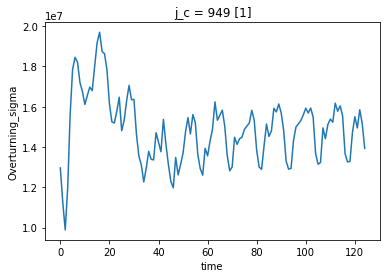

In [18]:
ds_drift['Overturning_sigma'].isel(r=0,j_c=250).max(dim='sigma0').plot()
print(ds_drift.latitude.values[0,0,250])

In [33]:
print(ds_drift.sigma0.values[33:39])

[27.25 27.35 27.45 27.55 27.65 27.75]


In [101]:
print(ds_drift.sigma0.values[23:33])

[26.25 26.35 26.45 26.55 26.65 26.75 26.85 26.95 27.05 27.15]


In [48]:
ds_tmp.latitude.values

array(49.02913, dtype=float32)

In [14]:
ds_drift.lev.values[40:49]

array([ 565.29229736,  628.02600098,  697.25866699,  773.36828613,
        856.67895508,  947.44787598, 1045.85424805, 1151.99121094,
       1265.8614502 ])

#### Heat Budget timeseries and overturning anomalies for NAO+ events

1. Timeseris of area-integrated heat budget terms (50N-70N, 60W-10W)
2. 

In [63]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['tos', 'Heat_Budget']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

ds_NAOp = ds_NAOp.assign_coords(time=tim.isel(time=slice(0,101)))
ds_NAOn = ds_NAOn.assign_coords(time=tim.isel(time=slice(0,101)))

#ds_NAOp = ds_NAOp.mean('comp')
#ds_NAOn = ds_NAOn.mean('comp')

print(ds_NAOp)

ds_psi_NAOp = xr.open_dataset(ppdir + "Composite_NAOp_Overturning.nc", chunks={'time':1})

ds_psi_NAOn = xr.open_dataset(ppdir + "Composite_NAOn_Overturning.nc", chunks={'time':1})

ds_psi_NAOp = ds_psi_NAOp.assign_coords(time=tim.isel(time=slice(0,101)))
ds_psi_NAOn = ds_psi_NAOn.assign_coords(time=tim.isel(time=slice(0,101)))

print(ds_psi_NAOp)

<xarray.Dataset>
Dimensions:                          (j: 321, i: 361, comp: 114, time: 101)
Coordinates:
  * j                                (j) int32 780 781 782 ... 1098 1099 1100
  * i                                (i) int32 810 811 812 ... 1168 1169 1170
    latitude                         (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude                        (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    nav_lat                          (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    nav_lon                          (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
  * time                             (time) object 1960-11-16 00:00:00 ... 19...
Dimensions without coordinates: comp
Data variables:
    tos                              (comp, time, j, i) float32 dask.array<chunksize=(114, 1, 321, 361), meta=np.ndarray>
    Heat_Content_200                 (time, j, i) float32 dask.array<chunk

In [6]:
ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")

dA = ds_grid['area_t'].isel(y=slice(780-699, 1100-699+1), x=slice(810-749,1170-749+1)).rename({'y':'j', 'x':'i'})

print(dA, mask_NA)

<xarray.DataArray 'area_t' (j: 321, i: 361)>
[115881 values with dtype=float32]
Coordinates:
    nav_lat  (j, i) float32 ...
    nav_lon  (j, i) float32 ...
Dimensions without coordinates: j, i
Attributes:
    standard_name:  cell_area
    units:          m2


In [18]:
dA_50N_70N = dA.where((ds_NAOp['tos'].isel(time=0,comp=0) < 100.) & (dA.nav_lat >=50.) &
                                    (dA.nav_lat < 70.) & (dA.nav_lon >=-60.) & (dA.nav_lon < -10.)).compute()

CPU times: user 1.62 s, sys: 353 ms, total: 1.97 s
Wall time: 1.29 s
CPU times: user 1.6 s, sys: 446 ms, total: 2.04 s
Wall time: 1.16 s


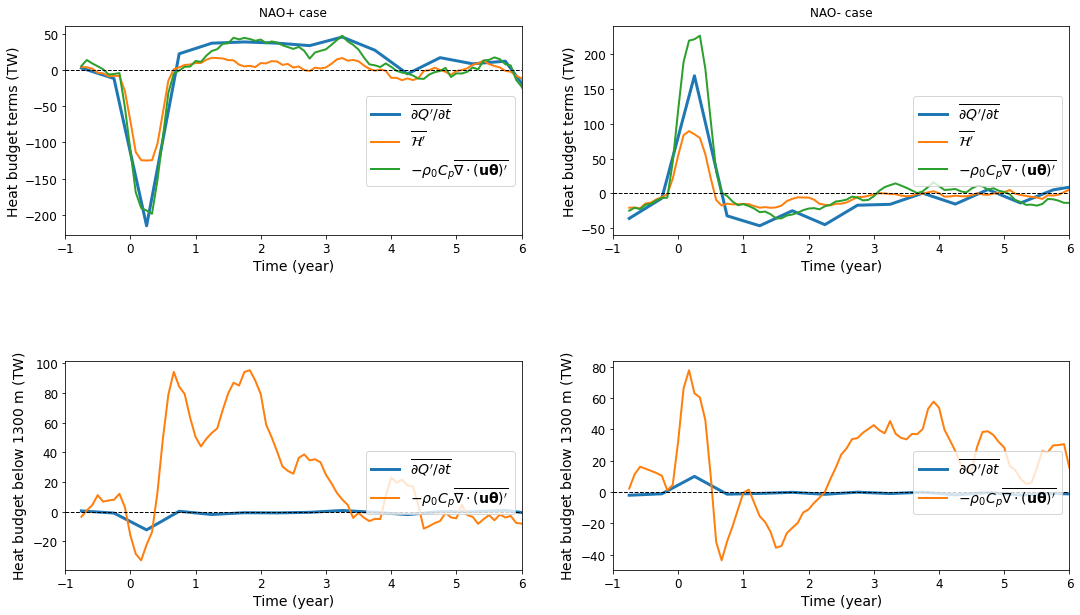

In [61]:
win_rol = 6

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.6)
fig = plt.figure(figsize=[18,10])

for i in range(0,2):
    
    if(i==0):
        %time ds_tmp = (ds_NAOp.drop('tos') * dA_50N_70N).sum(['i', 'j']).compute()
    else:
        %time ds_tmp = (ds_NAOn.drop('tos') * dA_50N_70N).sum(['i', 'j']).compute()
        
    HF = ds_tmp['hfds'].rolling(time=win_rol, center=False).mean('time') / 1e12
    Hor_flx = - (ds_tmp['Heat_Divergence_Horizontal_200'] + 
                 ds_tmp['Heat_Divergence_Horizontal_1300']).rolling(time=win_rol, 
                                                                    center=False).mean('time') / 1e12
    Ver_flx = - (ds_tmp['Heat_Divergence_Vertical_200'] + 
                 ds_tmp['Heat_Divergence_Vertical_1300']).rolling(time=win_rol, 
                                                                     center=False).mean('time') / 1e12
    tmp = (ds_tmp['Heat_Content_200'] + ds_tmp['Heat_Content_1300']).drop('time')
    dQ_dt = ((-tmp.isel(time = slice(0,101-win_rol,win_rol))
             + tmp.isel(time = slice(0+win_rol,101,win_rol))) / 
             (24.*3600.*30.*win_rol)) / 1e12
    
    ax = fig.add_subplot(grid1[0, i])
    ax.plot(np.arange(len(dQ_dt.time))*win_rol/12 + win_rol/12 - 1 - win_rol/(2*12), dQ_dt, lw = 3., 
            label=r'$\overline{\partial Q^{\prime}/\partial t}$')
    ax.plot(np.arange(len(HF.time))/12 + 1/12 - 15/12, HF, lw = 2.,  label=r'$\overline{\mathcal{H}^{\prime}}$')
    ax.plot(np.arange(len(HF.time))/12 + 1/12 - 15/12, Hor_flx + Ver_flx, lw = 2.,  
            label=r'$-\rho_0C_p\overline{\nabla\cdot({\bf{u}\theta})^{\prime}}$')
    
    ax.axhline(y=0, ls='--', lw=1, color='k')
    ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel(r'Heat budget terms (TW)', fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1., 0.7), fontsize=14)
    plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
    ax.set_xlim([-1., 6.])
    if(i==0):
        ax.set_title(r'NAO+ case', pad=10, fontsize=12)
    else:
        ax.set_title(r'NAO- case', pad=10, fontsize=12)
        
    Hor_flx = - (ds_tmp['Heat_Divergence_Horizontal'] - ds_tmp['Heat_Divergence_Horizontal_200'] - 
                 ds_tmp['Heat_Divergence_Horizontal_1300']).rolling(time=win_rol, 
                                                                    center=False).mean('time') / 1e12
    Ver_flx = - (ds_tmp['Heat_Divergence_Vertical'] - ds_tmp['Heat_Divergence_Vertical_200'] + 
                 ds_tmp['Heat_Divergence_Vertical_1300']).rolling(time=win_rol, 
                                                                     center=False).mean('time') / 1e12
    tmp = (ds_tmp['Heat_Content'] - ds_tmp['Heat_Content_200'] - ds_tmp['Heat_Content_1300']).drop('time')
    dQ_dt = ((-tmp.isel(time = slice(0,101-win_rol,win_rol))
             + tmp.isel(time = slice(0+win_rol,101,win_rol))) / 
             (24.*3600.*30.*win_rol)) / 1e12
    
    ax = fig.add_subplot(grid1[1, i])
    ax.plot(np.arange(len(dQ_dt.time))*win_rol/12 + win_rol/12 - 1 - win_rol/(2*12), dQ_dt, lw = 3., 
            label=r'$\overline{\partial Q^{\prime}/\partial t}$')
    #ax.plot(np.arange(len(HF.time))/12 + 1/12 - 15/12, HF, lw = 2.,  label=r'$\overline{\mathcal{H}^{\prime}}$')
    ax.plot(np.arange(len(HF.time))/12 + 1/12 - 15/12, Hor_flx + Ver_flx, lw = 2.,  
            label=r'$-\rho_0C_p\overline{\nabla\cdot({\bf{u}\theta})^{\prime}}$')
    
    ax.axhline(y=0, ls='--', lw=1, color='k')
    ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel(r'Heat budget below $1300$ m (TW)', fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1., 0.6), fontsize=14)
    plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
    ax.set_xlim([-1., 6.])

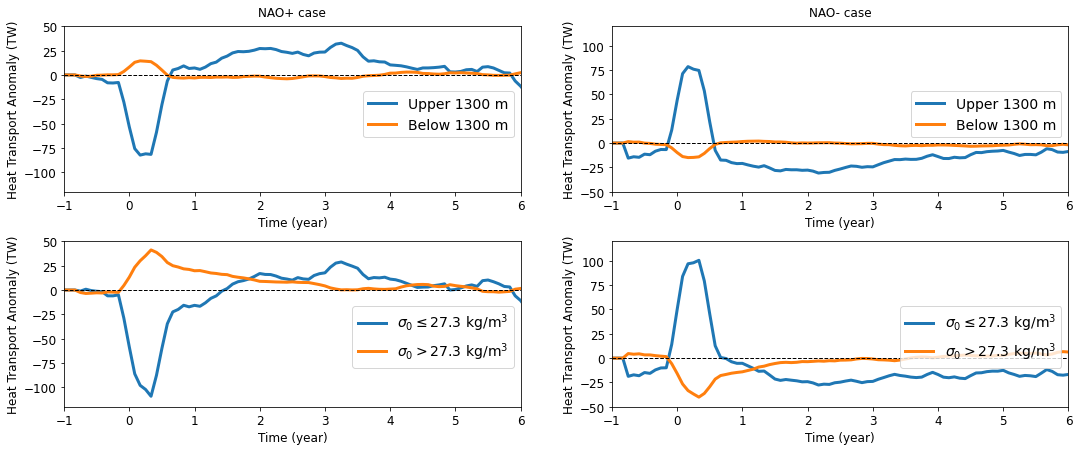

In [73]:
grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3)
fig = plt.figure(figsize=[18,7])

for i in range(0,2):
    
    if(i==0):
        ds_tmp = ds_psi_NAOp.isel(j_c=slice(0,303))
    else:
        ds_tmp = ds_psi_NAOn.isel(j_c=slice(0,303))
        
    ds_tmp = ds_tmp.assign_coords(j_c=ds_psi_NAOp['latitude'].isel(j_c=slice(0,303)))

    ds_tmp = ds_tmp.sel(j_c=50., method='nearest')
    ds_tmp = ds_tmp.mean('comp').rolling(time=win_rol, center=False).mean('time')
    
    ax = fig.add_subplot(grid1[0, i])
    ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
            (ds_tmp['MHT_z']).isel(lev=slice(0,49)).sum('lev')/1e12, 
            lw=3., ls='-', label =r'Upper 1300 m')
    ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
            (ds_tmp['MHT_z']).isel(lev=slice(49,75)).sum('lev')/1e12, 
            lw=3., ls='-', label =r'Below 1300 m')
    
    ax.axhline(y=0, ls='--', lw=1, color='k')
    ax.set_xlim([-1., 6.])
    plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
    plt.legend(loc='upper right', bbox_to_anchor=(1., 0.65), fontsize=14)
    ax.set_ylabel('Heat Transport Anomaly (TW)', fontsize=12)
    ax.set_xlabel('Time (year)', fontsize=12)
    
    if(i==0):
        ax.set_title(r'NAO+ case', pad=10, fontsize=12)
        ax.set_ylim([-120., 50.])
    else:
        ax.set_title(r'NAO- case', pad=10, fontsize=12)
        ax.set_ylim([-50., 120.])
        
    ax = fig.add_subplot(grid1[1, i])
    ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
            (ds_tmp['MHT_sigma']).isel(sigma0=slice(0,34)).sum('sigma0')/1e12, 
            lw=3., ls='-', label =r'$\sigma_0 \leq 27.3$ kg/m$^3$')
    ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
            (ds_tmp['MHT_sigma']).isel(sigma0=slice(34,-1)).sum('sigma0')/1e12, 
            lw=3., ls='-', label =r'$\sigma_0 > 27.3$ kg/m$^3$')
    
    ax.axhline(y=0, ls='--', lw=1, color='k')
    ax.set_xlim([-1., 6.])
    if(i==0):
        ax.set_ylim([-120., 50.])
    else:
        ax.set_ylim([-50., 120.])
    plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
    plt.legend(loc='upper right', bbox_to_anchor=(1., 0.65), fontsize=14)
    ax.set_ylabel('Heat Transport Anomaly (TW)', fontsize=12)
    ax.set_xlabel('Time (year)', fontsize=12)

Text(0.5, 0, 'Time (year)')

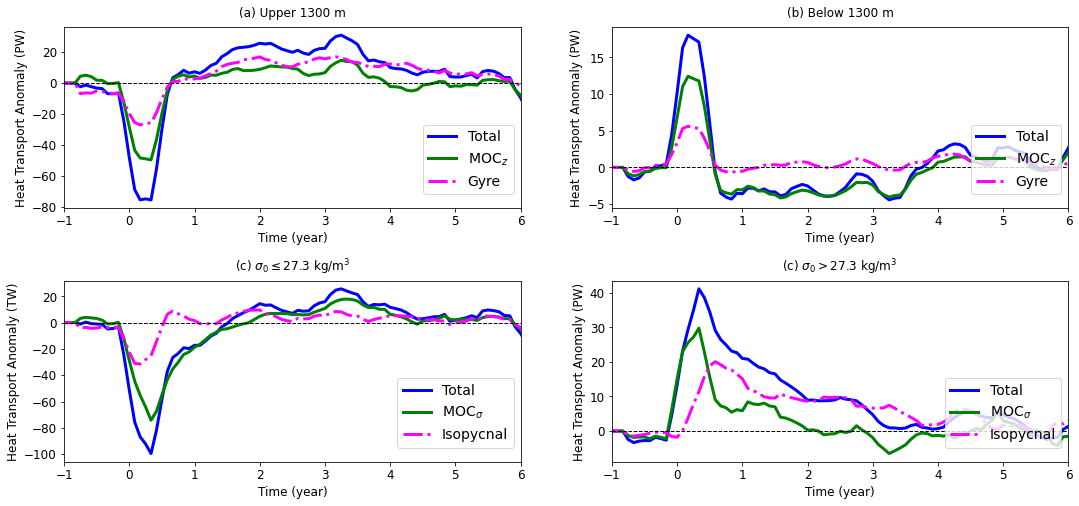

In [89]:
col = plt.cm.Set1(np.linspace(0.,0.55,3))

ds_tmp = ds_psi_NAOp.isel(j_c=slice(0,303))
ds_tmp = ds_tmp.assign_coords(j_c=ds_psi_NAOp['latitude'].isel(j_c=slice(0,303)))

ds_tmp = ds_tmp.sel(j_c=50.5, method='nearest')
ds_tmp = ds_tmp.mean('comp').rolling(time=win_rol, center=False).mean('time')

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[18,8])

ax = fig.add_subplot(grid1[0, 0])
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        (ds_tmp['MHT_z']).isel(lev=slice(0,49)).sum('lev')/1e12, 
        lw=3., color='blue', ls='-', label =r'Total')
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, ds_tmp['MHT_overturning_z'].isel(lev=slice(0,49)).sum('lev')/1e12, 
        lw=3., color='green', label =r'MOC$_z$')
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        (ds_tmp['MHT_z'] - ds_tmp['MHT_overturning_z']).isel(lev=slice(0,49)).sum('lev')/1e12, 
        lw=3., color='magenta', ls='-.', label =r'Gyre')
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlim([-1., 6.])
ax.set_title('(a) Upper 1300 m', pad=10, fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.5), fontsize=14)
ax.set_ylabel('Heat Transport Anomaly (PW)', fontsize=12)
ax.set_xlabel('Time (year)', fontsize=12)
#ax.set_ylim([-100., 50.])

ax = fig.add_subplot(grid1[0, 1])
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        (ds_tmp['MHT_z']).isel(lev=slice(49,-1)).sum('lev')/1e12, 
        lw=3., color='blue', ls='-', label =r'Total')
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, ds_tmp['MHT_overturning_z'].isel(lev=slice(49,-1)).sum('lev')/1e12, 
        lw=3., color='green', label =r'MOC$_z$')
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        (ds_tmp['MHT_z'] - ds_tmp['MHT_overturning_z']).isel(lev=slice(49,-1)).sum('lev')/1e12, 
        lw=3., color='magenta', ls='-.', label =r'Gyre')
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlim([-1., 6.])
ax.set_title('(b) Below 1300 m', pad=10, fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.5), fontsize=14)
ax.set_ylabel('Heat Transport Anomaly (PW)', fontsize=12)
ax.set_xlabel('Time (year)', fontsize=12)
#ax.set_ylim([-100., 50.])

ax = fig.add_subplot(grid1[1, 0])
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        (ds_tmp['MHT_sigma']).isel(sigma0=slice(0,34)).sum('sigma0')/1e12, 
        lw=3., color='blue', ls='-', label =r'Total')
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        ds_tmp['MHT_overturning_sigma'].isel(sigma0=slice(0,34)).sum('sigma0')/1e12, 
        lw=3., color='green', label =r'MOC$_{\sigma}$')
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        (ds_tmp['MHT_sigma'] - ds_tmp['MHT_overturning_sigma']).isel(sigma0=slice(0,34)).sum('sigma0')/1e12, 
        lw=3., color='magenta', ls='-.', label=r'Isopycnal')
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlim([-1., 6.])
ax.set_title(r'(c) $\sigma_0 \leq 27.3$ kg/m$^3$', pad=10, fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.5), fontsize=14)
ax.set_ylabel('Heat Transport Anomaly (TW)', fontsize=12)
ax.set_xlabel('Time (year)', fontsize=12)
#ax.set_ylim([-100., 50.])

ax = fig.add_subplot(grid1[1, 1])
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        (ds_tmp['MHT_sigma']).isel(sigma0=slice(34,-1)).sum('sigma0')/1e12, 
        lw=3., color='blue', ls='-', label =r'Total')
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        ds_tmp['MHT_overturning_sigma'].isel(sigma0=slice(34,37)).sum('sigma0')/1e12 +
        ds_tmp['MHT_sigma'].isel(sigma0=slice(37, -1)).sum('sigma0')/1e12, 
        lw=3., color='green', label =r'MOC$_{\sigma}$')
ax.plot(np.arange(len(ds_tmp.time))/12 + 1/12 - 15/12, 
        (ds_tmp['MHT_sigma'] - ds_tmp['MHT_overturning_sigma']).isel(sigma0=slice(34,37)).sum('sigma0')/1e12, 
        lw=3., color='magenta', ls='-.', label=r'Isopycnal')
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_xlim([-1., 6.])
ax.set_ylabel('Heat Transport Anomaly (PW)', fontsize=12)
ax.set_title(r'(c) $\sigma_0 > 27.3$ kg/m$^3$', pad=10, fontsize=12)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.5), fontsize=14)
ax.set_xlabel('Time (year)', fontsize=12)
#ax.set_ylim([-100., 50.])
